In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import argparse
from scipy.stats import chisquare

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.basemap import Basemap as Basemap

from scipy import stats

def get_KMeans(values, k):
    # Convert the list to a numpy array
    X = np.array(values).reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k,n_init="auto",random_state=42)
    kmeans.fit(X)

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Initialize lists for each cluster
    clusters = [[] for _ in range(k)]

    # Assign each value to its corresponding cluster
    for value, label in zip(values, cluster_labels):
        clusters[label].append(value)

    return sorted(clusters, key=lambda x: x[0])

def get_agglo(values, k):
  X = np.array(values).reshape(-1, 1)

  agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')

  # Fit the model to the data
  agg_clustering.fit(X)

  labels = agg_clustering.labels_

  return labels

def get_agglo_2d(x,y,k):
  X = np.array(x).reshape(-1, 1)
  Y = np.array(y).reshape(-1, 1)

  agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')

  # Fit the model to the data
  agg_clustering.fit(np.concatenate((X, Y), axis=1))

  labels = agg_clustering.labels_

  return labels

def find_elbow(x,y,dt):
  X = np.array(x).reshape(-1, 1)
  Y = np.array(y).reshape(-1, 1)

  agg_clustering = AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=dt)

  # Fit the model to the data
  agg_clustering.fit(np.concatenate((X, Y), axis=1))

  return agg_clustering.n_clusters_

137
137


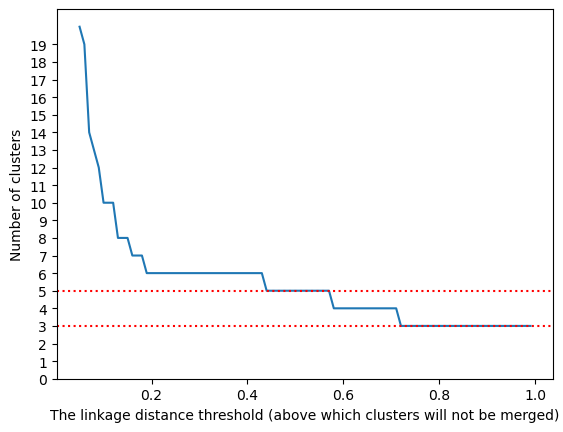

In [9]:
file = "NW_022145601.1_28950395_29566247" #"NW_022145610.1_30779143_31460853" "NW_022145606.1_16610900_16737625" #
# "12702886_13424367", 15422748_16793794
df1 = f"{file}_dim1.csv"
df2 = f"{file}_dim2.csv"
k=3
perc_explained = f"{file}_perc_explained.csv"

df1=pd.read_csv(df1)
df2=pd.read_csv(df2)
dim1=df1["dim1"].tolist()
dim2=df2["dim2"].tolist()

print(len(dim1))
print(len(dim2))

pe=pd.read_csv(perc_explained,names=["pes"])
pes_list=pe.pes.to_list()

dim=np.array(list(zip(dim1,dim2)))
pops=["BOD", "CAP", "FOG", "KIB", "LOM", "SAN", "TER"]
tpop=[]
for p in pops:
  if p != "CAP" and p!= "FOG":
    tpop.append([p] * 20)
  else:
    if p == "CAP":
      tpop.append([p] * 19)
    if p == "FOG":
      tpop.append([p] * 18)

pops=np.array([x for xs in tpop for x in xs]) #np.array([item for item in pops for _ in range(20)])
ind_id=np.array(list(range(1,len(pops)+1)))

NUM_CLUST=k

f_clusts=[]
for i in np.arange(0.05,1,0.01):
  f_clusts.append(find_elbow(dim1,dim2,i))

plt.plot(np.arange(0.05,1,0.01), f_clusts)
plt.axhline(3,color="red",linestyle=":")
plt.axhline(5,color="red",linestyle=":")
plt.ylim(0,max(f_clusts)+1)
plt.yticks(np.arange(0, max(f_clusts), step=1))
plt.ylabel("Number of clusters")
plt.xlabel("The linkage distance threshold (above which clusters will not be merged)")
plt.show()

0 yellow
28
1 green
39
2 purple
26
3 red
11
4 blue
17
5 orange
16


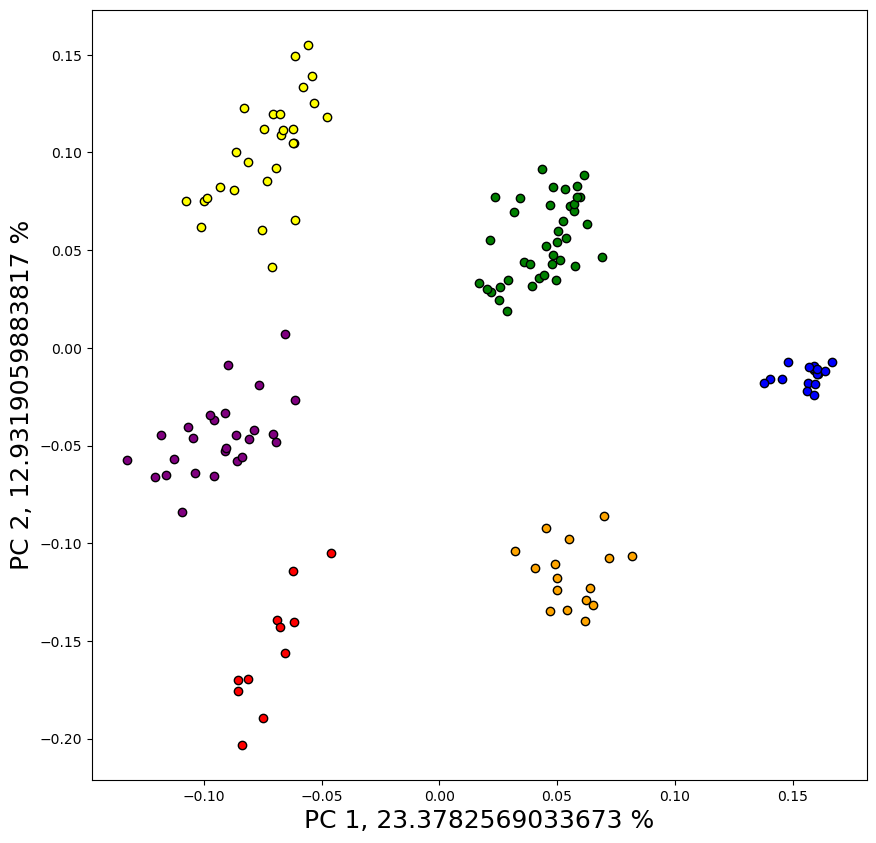

In [10]:
NUM_CLUST = 6
if NUM_CLUST == 3:
  clusts=get_agglo(dim1, NUM_CLUST)
else:
  clusts=get_agglo_2d(dim1,dim2,NUM_CLUST)

all_cols=["yellow","green","purple",'red', 'blue', 'orange', 'cyan', 'magenta', 'brown', 'lime']
p_colors= all_cols[:NUM_CLUST]
pca_colors = ["purple", "green","yellow"]

f, axs = plt.subplots(figsize=(10, 10))

gts=["AC", "BC", "AB", "AA", "CC", "BB"]

pop_dic={}
id_dic={}
for c in range(NUM_CLUST):
  t=np.where(np.array(clusts) == c)[0]
  print(c, p_colors[c])
  print(len(t))
  x=[i[0] for i in dim[t]]
  y=[i[1] for i in dim[t]]
  plt.scatter(x,y,edgecolors="black",c=p_colors[c])
  avx=sum(x)/len(x)
  ids=pops[t]
  pop_dic[c]=[avx,ids]
  id_dic[c]=[avx,ind_id[t]]
plt.ylabel("PC 2, "+str(pes_list[1])+" %",fontsize=18)
plt.xlabel("PC 1, "+str(pes_list[0])+" %",fontsize=18)
plt.show()

In [11]:
pops=["KIB", "LOM", "SAN", "TER"]
x=np.repeat(np.array(["BOD"]),20,axis=0)
b=np.repeat(np.array(["CAP"]),19,axis=0)
a=np.repeat(np.array(["FOG"]),18,axis=0)
c=np.repeat(np.array(pops),20,axis=0)
pops=np.concatenate([x,b,a,c])

In [12]:
pdic=defaultdict(list)
pdic2=defaultdict(list)
for i in range(len(clusts)):
    mk=gts[clusts[i]]
    pdic[mk].append(pops[i])
    pdic2[pops[i]].append(gts[clusts[i]])
Counter(pdic["CC"])

Counter({'LOM': 7, 'TER': 4, 'SAN': 3, 'KIB': 2, 'CAP': 1})

In [13]:
#Turning it into allele frequencies, from genotypes
pdic3=defaultdict(list)
for k in pdic.keys():
    #print(k[0],k[1])
    #print(pdic[k])
    for p in pdic[k]:
        pdic3[p].append(k[0])
        pdic3[p].append(k[1])

pdic4=defaultdict(list)
for k in pdic3.keys():
    for k2 in Counter(pdic3[k]).keys():
        for i in range(Counter(pdic3[k])[k2]):
            pdic4[k2].append(k)

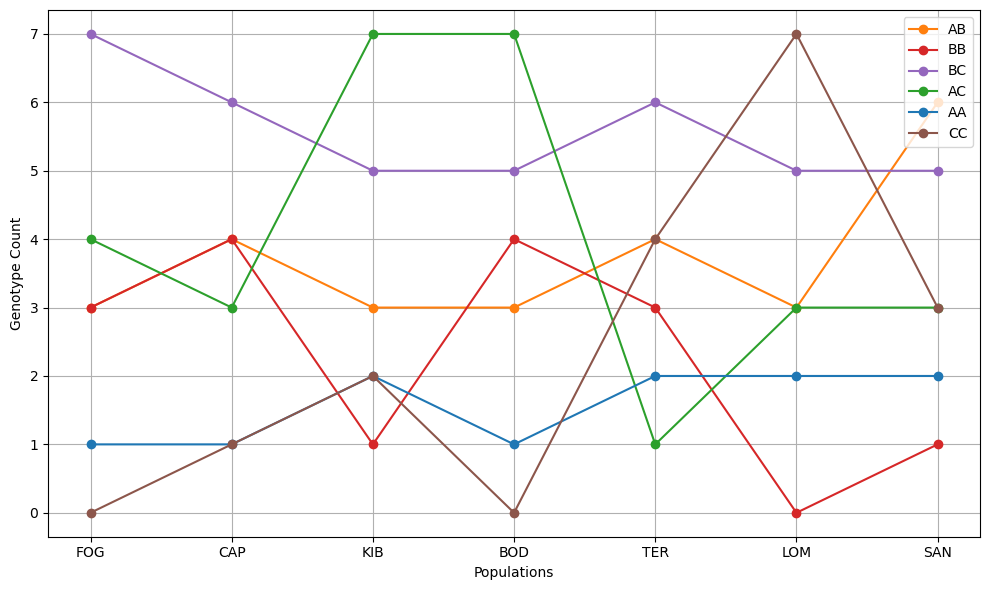

In [14]:
# Sample dictionary with three-letter strings as values
data = pdic
# Get all unique three-letter strings across all keys
all_strings = set([item for sublist in data.values() for item in sublist])
all_strings = sorted(all_strings)  # Sorting for consistent x-axis order

color_mapping = {
    'AA': 'C0',
    'AB': 'C1',
    'AC': 'C2',
    'BB': 'C3',
    'BC': 'C4',
    'CC': 'C5'
}

custom_order = ["FOG","CAP","KIB","BOD","TER","LOM","SAN"]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each key as a line
for key, values in data.items():
    # Count occurrences of each string in the list
    counts = Counter(values)
    
    # Prepare y-values for the plot based on all_strings order
    #y_values = [counts[string] for string in all_strings]
    y_values = [counts[string] for string in custom_order]
    
    # Plot the line
    plt.plot(custom_order, y_values, marker='o', label=key,color=color_mapping.get(key, 'black'))

# Add labels, legend, and title
plt.xlabel('Populations')
plt.ylabel('Genotype Count')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


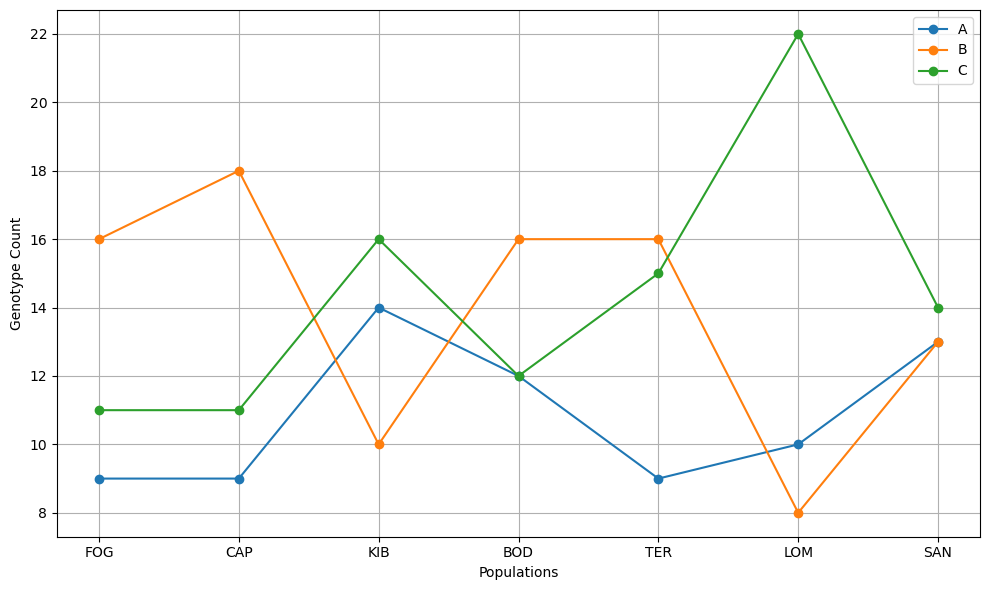

In [15]:
# Sample dictionary with three-letter strings as values
data = pdic4
# Get all unique three-letter strings across all keys
all_strings = set([item for sublist in data.values() for item in sublist])
all_strings = sorted(all_strings)  # Sorting for consistent x-axis order

color_mapping = {
    'A': 'C0',
    'B': 'C1',
    'C': 'C2'
}

custom_order = ["FOG","CAP","KIB","BOD","TER","LOM","SAN"]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each key as a line
freqs=[]
for key, values in data.items():
    # Count occurrences of each string in the list
    counts = Counter(values)
    
    # Prepare y-values for the plot based on all_strings order
    #y_values = [counts[string] for string in all_strings]
    y_values = [counts[string] for string in custom_order]
    freqs.append(y_values)
    
    # Plot the line
    plt.plot(custom_order, y_values, marker='o', label=key,color=color_mapping.get(key, 'black'))

# Add labels, legend, and title
plt.xlabel('Populations')
plt.ylabel('Genotype Count')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
freqs

[[9, 9, 14, 12, 9, 10, 13],
 [16, 18, 10, 16, 16, 8, 13],
 [11, 11, 16, 12, 15, 22, 14]]

In [17]:
NS_coordinates = [44.840000, 42.840000, 39.60412, 38.3182, 36.94841, 34.718893, 32.651389]
slope, intercept, r_value, p_value, std_err = stats.linregress(NS_coordinates, freqs[2])
print(slope, r_value, p_value)

-0.5527560433433889 -0.615309326716768 0.14135792533046096


In [103]:
A=len(pdic4["A"])
B=len(pdic4["B"])
C=len(pdic4["C"])

obs=[]
exp=[]
for k in pdic.keys(): #all possible genotypes
    obs.append(len(pdic[k]))
    print(k)
    frq0=len(pdic4[k[0]])/(137*2)
    frq1=len(pdic4[k[1]])/(137*2)
    if k[0] == k[1]: #homozygote
        genoexp = frq0*frq0*137
    else:
        genoexp = 2*frq0*frq1*137
    exp.append(genoexp)

result = chisquare(f_obs=obs, f_exp=exp)
print(result)

AB
BB
BC
AC
AA
CC
Power_divergenceResult(statistic=0.5647299779506201, pvalue=0.9895610937661241)


In [101]:
obs

[26, 16, 39, 28, 11, 17]

In [102]:
exp

[26.905109489051096,
 17.169708029197082,
 35.75547445255474,
 28.014598540145986,
 10.540145985401459,
 18.614963503649637]

In [63]:
colors=["yellow","green","purple",'red', 'blue', 'orange', 'cyan', 'magenta', 'brown', 'lime']
colors = plt.cm.tab10.colors #['blue', 'green', 'red', 'purple', 'orange', 'brown', 'magenta']
markers = ['o', 's', '^', 'D', '*', 'p', 'X']

coldic={}
c=0
for p in pops:
    if p not in coldic.keys():
        coldic[p] = colors[c]
        c+=1

mardic={}
c=0
for p in pops:
    if p not in mardic.keys():
        mardic[p] = markers[c]
        c+=1

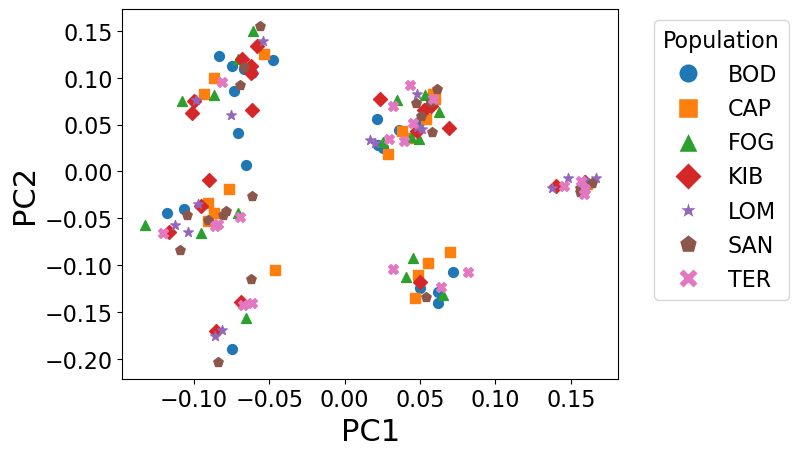

In [64]:
for i in range(len(df1["dim1"])):
    plt.scatter(df1["dim1"].to_list()[i], df2["dim2"].to_list()[i],color=coldic[pops[i]],marker=mardic[pops[i]],s=50)

legend_handles = []
c=0
for label, color in coldic.items():
    legend_handles.append(plt.Line2D([0], [0], marker=mardic[label], color='w', markerfacecolor=color, markersize=14, label=label))
    c+=1

# Add the legend to the plot
plt.legend(handles=legend_handles,loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=16,title="Population",title_fontsize=16)

plt.ylabel("PC2", fontsize=22)
plt.xlabel("PC1", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig("figs/609_pop_PCA.pdf", format='pdf', bbox_inches='tight')